Summary and Description
Objective
The objective is to perform sentiment analysis on a movie review dataset using BERT (Bidirectional Encoder Representations from Transformers). The task involves text processing, review clustering, and sentiment intensity analysis.

Dataset Overview
The dataset contains two columns:

text: The movie review text, which are long sentences, most longer than 200 words.
label: The sentiment label associated with each review (e.g., positive, negative).
Steps and Approach
Installing Dependencies:

Install required libraries: transformers, torch, pandas, scikit-learn, matplotlib, seaborn.
Importing Dependencies:

Import necessary modules for data manipulation, tokenization, model training, and evaluation.
Loading the Dataset:

Load the dataset into a pandas DataFrame.
Preprocessing the Data:

Tokenize the reviews using BERT tokenizer.
Truncate or pad the reviews to meet BERT's input length requirement (512 tokens).
Split the dataset into training and test sets.
Creating a BERT Model:

Initialize the BERT model for sequence classification.
Training the Model:

Define training arguments and create a Trainer instance.
Train the model using the training dataset.
Evaluating the Model:


# Sentiment analysis using BERT

# Task
Review Dataset Text Processing

# Objective

Perform text processing with reviews clustering and sentiment intensity.

# Dataset overview

Context
A movie review dataset. NLP tasks Sentiment Analysis.

Note : all the movie review are long sentence(most of them are longer than 200 words.)

Content
two columns used (text : the review of the movie and label : the sentiment label of the movie review)

About the file

Movie reviews are located in text field.
Sentiment label are located in label field.


## Installing and importing dependencies

First let us import all the modules and packages that will be required.

Installing Dependencies
To work with BERT and perform sentiment analysis, we need to install the following libraries:

transformers for BERT
torch for PyTorch
pandas for data manipulation
scikit-learn for preprocessing and evaluation
matplotlib and seaborn for visualization


In [1]:
# A dependency of the preprocessing for BERT inputs
!pip data.shapeinstall -q tensorflow-text

In [2]:
!pip install -q tf-models-official

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Loading and Exploring dataset




In [14]:
data = pd.read_csv('Reviews.csv')

In [5]:
data.shape

(50000, 2)

Thus there are 50000 rows and 2 columns in the `data` dataframe 

In [15]:
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


As we can see the `sentiment` column has 2 values:

   * Negative Sentiment
   * Postive Sentiment
  

In [7]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

Now we encode the positive sentiment to 1 and negative sentiment to 0

In [16]:
labeling = {
    'positive':1, 
    'negative':0
}

data['sentiment'] = data['sentiment'].apply(lambda x : labeling[x])
# Output first ten rows
data.head(10)


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


Thus, there are no missing values in any of the columns of the dataset.

## Visualization

<AxesSubplot:xlabel='sentiment'>

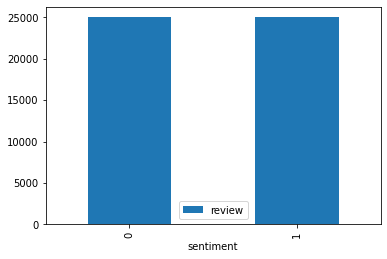

In [17]:
data.groupby('sentiment').count().plot(kind='bar')

This is a good thing since it means our dataset is not skewed.

<AxesSubplot:>

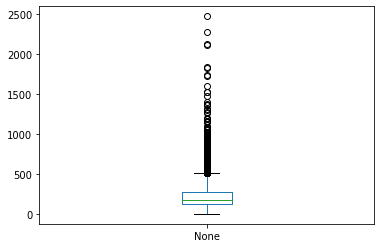

In [47]:
review_len = pd.Series([len(review.split()) for review in data['review']])
review_len.plot(kind='box')

Now, let us visualize how long our sentences are in the training data.

<AxesSubplot:ylabel='Count'>

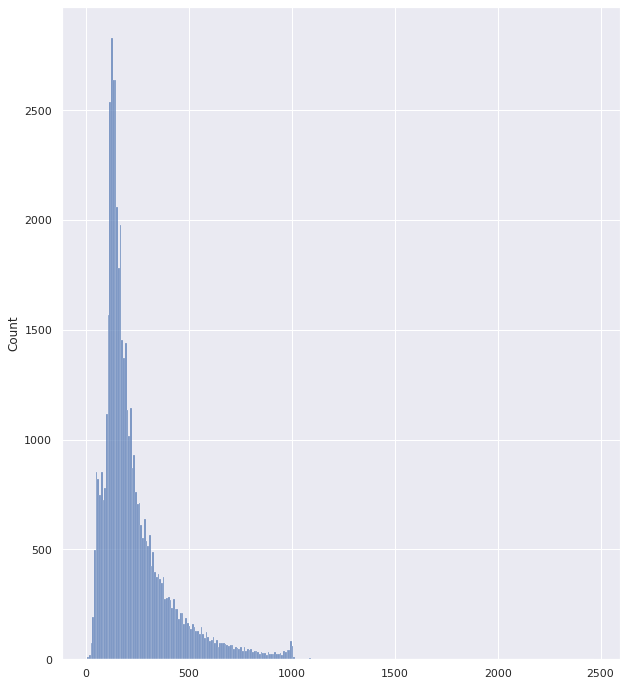

In [48]:
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None,
)

plt.figure(figsize = (10,12))
sns.histplot(review_len)

## BERT

BERT (Bidirectional Encoder Representations from Transformers) is a recent paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others.


## Loading model from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.


Here, we have used a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.


In [18]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.


In [19]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [55]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [20]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

## Defining model

We have created a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

In [21]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

## Model training

Next we train a model since we have the preprocessing module, BERT encoder, data, and classifier.

### Loss function


In [24]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer


In [25]:
epochs = 5
steps_per_epoch = 625
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [26]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [1]:
X_train = train_data['text']
y_train = train_data['label']
X_valid = valid_data['text']
y_valid = valid_data['label']

NameError: name 'train_data' is not defined

In [40]:
X = data['review']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.review, data.sentiment, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.16, random_state=1) # 0.25 x 0.8 = 0.
print('Number of reviews in the total set : {}'.format(len(X)))
print('Number of reviews in the training set : {}'.format(len(X_train)))
print('Number of reviews in the validation set : {}'.format(len(X_valid)))
print('Number of reviews in the testing set : {}'.format(len(X_test)))

Number of reviews in the total set : 50000
Number of reviews in the training set : 33600
Number of reviews in the validation set : 5000
Number of reviews in the testing set : 10000


In [41]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(X_train, y_train,
                               validation_data=(X_valid, y_valid),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
1050/1050 [==============================] - 206s 190ms/step - loss: 0.5348 - binary_accuracy: 0.7015 - val_loss: 0.3156 - val_binary_accuracy: 0.8646
Epoch 2/5
1050/1050 [==============================] - 199s 190ms/step - loss: 0.3086 - binary_accuracy: 0.8611 - val_loss: 0.2535 - val_binary_accuracy: 0.8924
Epoch 3/5
1050/1050 [==============================] - 200s 190ms/step - loss: 0.2326 - binary_accuracy: 0.9022 - val_loss: 0.2343 - val_binary_accuracy: 0.9092
Epoch 4/5
1050/1050 [==============================] - 200s 191ms/step - loss: 0.2037 - binary_accuracy: 0.9170 - val_loss: 0.2343 - val_binary_accuracy: 0.9092
Epoch 5/5
1050/1050 [==============================] - 200s 191ms/step - loss: 0.2027 - binary_accuracy: 0.9150 - val_loss: 0.2343 - val_binary_accuracy: 0.9092


## Evaluate the model



In [42]:
#X_test = test_data['text']
#y_test = test_data['label']
loss, accuracy = classifier_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 33s 107ms/step - loss: 0.3304 - binary_accuracy: 0.8681
Loss: 0.3304141163825989
Accuracy: 0.8680999875068665


 Testing our model on any sentence we want, by adding to the `examples` variable below.

In [46]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  
    'The movie was great!',
    'The movie was meh.',
    'The movie was idiotic.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.997652
input: The movie was great!           : score: 0.987674
input: The movie was meh.             : score: 0.438580
input: The movie was idiotic.         : score: 0.002172
input: The movie was terrible...      : score: 0.001972

Results from the model in memory:
input: this is such an amazing movie! : score: 0.997652
input: The movie was great!           : score: 0.987674
input: The movie was meh.             : score: 0.438580
input: The movie was idiotic.         : score: 0.002172
input: The movie was terrible...      : score: 0.001972

